# DATA PREPARATION

The preparation implied by this notebook is better explained (and is derived from) in Data_preparation-fast_run_saterday_31_March 

In [1]:
%matplotlib inline

In [2]:
import datetime
start =  datetime.datetime.now()
print datetime.datetime.now()

2019-05-06 14:34:03.767000


In [3]:
import matplotlib.pyplot as plt

In [4]:
from __future__ import division
import pandas as pd ; pd.set_option("display.max_columns",200)
import numpy as np

In [5]:
store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/edp_2015_final.h5'
reaction_store_path = u"C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Programme/Réaction offre de travail/hdf/data_preparation_step_1.h5"
Store = pd.HDFStore(store_path)

In [6]:
def load_fisc_i_by_year(year = 2014):
    df_fisci = pd.read_hdf(store_path, 'FISC_INDIVIDU_{}'.format(year))
    return df_fisci
def load_fisc_r_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_REVENU_{}'.format(year))
    return df_fiscr
def load_fisc_l_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_LOGEMENT_{}'.format(year))
    return df_fiscr

def load_df_fiscrevdet_by_year(year = 2015):
    df_fiscrevdet = pd.read_hdf(store_path, 'FISC_REVDET_{}'.format(year))
    return df_fiscrevdet
    

In [7]:
### Start compare 2016

In [8]:
fisc_individu = load_fisc_i_by_year(year = 2011)

In [9]:
print fisc_individu.shape

(7521928, 28)


In [10]:
fisc_revenu = load_fisc_r_by_year(2011)

In [11]:
fisc_individu["CIDECI"]= fisc_individu.CIDECI.astype("str")


In [12]:
#Test qu'il n'y a pas de duplicate dans la base
assert (fisc_revenu.ID_FISC_LOG_DIFF.duplicated()).value_counts().index == False

In [13]:
%%time
grpby_fisci = (fisc_individu.groupby("ID_FISC_LOG_DIFF").CIDECI.sum())

Wall time: 1min 50s


In [14]:
grpby_fisci.value_counts().head(10)

MM       429127
MMAA     291867
C        176085
MMA      165763
MMAAA    145439
V        109483
D         89961
CC        74012
CMM       45727
MMC       45203
dtype: int64

In [15]:
df = pd.DataFrame()
df["MMAA"] = (grpby_fisci == "MMAA")
df["CIDECI"] = grpby_fisci.values
MMAA_id_fisc_log_diff = df[df.MMAA == True].index
fisc_revenu_MMAA = fisc_revenu[fisc_revenu.ID_FISC_LOG_DIFF.isin(MMAA_id_fisc_log_diff)]
fisc_revenu_MMAA.NBFOYM.value_counts(normalize = True).head(3)

1    0.998804
2    0.001165
4    0.000014
dtype: float64

In [16]:
MMAA_id_fisc_log_diff_2_fiscfoy = fisc_revenu_MMAA.query("NBFOYM>1").ID_FISC_LOG_DIFF

In [16]:
del fisc_revenu_MMAA, fisc_revenu

In [17]:
del grpby_fisci, fisc_individu

In [18]:
import gc
gc.collect()

68

In [19]:
var_to_sum_for_groupby = ["CNCOIPV", 'TYPE_PRES',
         'POIDS_FIDELI',
          'REV_PRINC', 'YSALI', 'YCHOI', 'YRSTI', 'YALRI', 'YRAGI', 'YBICI','YBNCI',
'YSALI_men', 'YSALI_wo', 'YCHOI_men', 'YCHOI_wo', 'YRSTI_men', 'YRSTI_wo', #On somme sur toutes la variables sexualisées NAN + 3 = 3
'YALRI_men', 'YALRI_wo', 'YRAGI_men', 'YRAGI_wo', 'YBICI_men', 'YBICI_wo', 'YBNCI_men', 'YBNCI_wo', 'ID_DIFF_wo',
'ID_DIFF_me', 'Age_men', 'Age_wo'
         ] #TODO: TYPE_PRES individus multiidentifiés
var_to_first_for_groupby = ["ID_FISC_FOY_DIFF", "ID_FISC_LOG_DIFF",  'ORDREFIP','DACOED', 
            'ZOXYZP', 'DACOEP','T_CHARGE','CSDEP',  'CNE1',  'I_FISC_LOGEMENT', 'I_FISC_REVENU',
            'TYPE_DECL','AN_FISC_y',]
var_to_drop = ["AN_FISC_x", 'COM_NSCAT','COM_SCAT1', 'COM_SCAT2', ] 

In [20]:
def create_rbg(df):
    df["Rbg"]=(( df.ZTSAM*0.9) + df.ZRAGM + df.ZRACM + df.ZRNCM + df.ZFONM + df.ZPERM*0.9
                    + df.ZRICM)
    return df

In [27]:
%%time
reaction_store = pd.HDFStore(reaction_store_path)

for year in [2010,2011,2012,2013,2014]:
    if "year_{}".format(year) in reaction_store: 
        print("Skip {} cause it already exists".format(year))
        continue
    
    df_fisci = load_fisc_i_by_year(year)
    df_fisc_revdet = load_df_fiscrevdet_by_year(year)

    df_fisc_revdet['TYPE_FISC'] = df_fisc_revdet.TYPE_FISC.astype('str')
    cols_revenu_individualize = df_fisc_revdet.columns[4:]; cols_revenu_individualize
    df_fisc_revdet.dropna(subset=["YSALI","YCHOI","YRSTI","YALRI","YRAGI","YBICI","YBNCI"], inplace = True)
    merge = pd.merge(df_fisci, df_fisc_revdet, on = ['ID_FISC_FOY_DIFF','ORDREFIP', 'TYPE_FISC'] )
    #Attention on a des NA qui sont présent dans la base fisc_revdet alors qu'on devrait avoir des zéros, je vire les observations. 
    #Vérifier que c'est ok potentiel TODO: en lien avec TODO suivant
    for col in cols_revenu_individualize:
        merge.loc[(merge.SEXE == 1),'{}_men'.format(col)] = merge[col] 
        merge.loc[(merge.SEXE == 2),'{}_wo'.format(col)] = merge[col]
    merge.loc[(merge.SEXE == 1), "Age_men" ] = (year - merge.ANAIS)
    merge.loc[(merge.SEXE == 2), "Age_wo" ] = (year - merge.ANAIS)

    col = "ID_DIFF"
    merge.loc[(merge.SEXE == 2),'{}_wo'.format(col)] = merge[col]
    merge.loc[(merge.SEXE == 1),'{}_me'.format(col)] = merge[col]

    groupby = merge[["Age_men", "Age_wo", "ID_FISC_LOG_DIFF"]].groupby("ID_FISC_LOG_DIFF").count()
    keep_ID_FISC_LOG_DIFF = groupby[(groupby.Age_men==1)& (groupby.Age_wo==1)].index #permet de sélectionner là ou il n'y a que deux adultes qui gagnent

    merge_keep = merge[merge.ID_FISC_LOG_DIFF.isin(keep_ID_FISC_LOG_DIFF)].sort("ID_FISC_LOG_DIFF")

    one_fisc_in_log = merge_keep.groupby("ID_FISC_LOG_DIFF")["ID_FISC_FOY_DIFF"].nunique()==1


    id_one_fisc_in_log = one_fisc_in_log[one_fisc_in_log].index
    merge_keep.sort("ID_FISC_LOG_DIFF", inplace = True)
    merge_keep_2 = merge_keep[merge_keep.ID_FISC_LOG_DIFF.isin(id_one_fisc_in_log)]

    df_1 = merge_keep_2.drop(labels = var_to_drop, axis = 1 )

    df_1_grpby_sum = df_1[["ID_FISC_LOG_DIFF"]+var_to_sum_for_groupby].groupby('ID_FISC_LOG_DIFF').sum()
    df_1_grpby_first = df_1[var_to_first_for_groupby].groupby('ID_FISC_LOG_DIFF').first()

    df_2 = pd.merge(df_1_grpby_first.reset_index(), df_1_grpby_sum.reset_index(), on = "ID_FISC_LOG_DIFF").reset_index()
    fiscr = load_fisc_r_by_year(year)
    fiscr = create_rbg(fiscr)
    df_merge_2 = df_2.merge(fiscr, on="ID_FISC_LOG_DIFF")
    print year, df_merge_2.shape
    df_merge_2.to_hdf(reaction_store_path, 'year_{}'.format(year))
reaction_store.close()

Skip 2010 cause it already exists
Skip 2011 cause it already exists
Skip 2012 cause it already exists
Skip 2013 cause it already exists
Skip 2014 cause it already exists
Wall time: 4 ms


In [30]:
try:
    del df_merge_2, fiscr, df_1_grpby_sum, df_1, df_1_grpby_first, merge_keep, merge_keep_2
    del one_fisc_in_log, merge, keep_ID_FISC_LOG_DIFF, df_fisc_revdet, df_fisci, id_one_fisc_in_log
    del MMAA_id_fisc_log_diff, MMAA_id_fisc_log_diff_2_fiscfoy, df, df_2
except: pass

In [27]:
import datetime
start =  datetime.datetime.now()
print datetime.datetime.now()

2019-05-06 14:10:58.924000


In [29]:
import gc

In [45]:
gc.collect()

0

In [31]:
df_2014 = pd.read_hdf(reaction_store_path, 'year_{}'.format(2014))

In [32]:
df_2011 = pd.read_hdf(reaction_store_path, 'year_{}'.format(2011))

In [33]:
print df_2011.shape; print df_2014.shape

(1051716, 142)
(941863, 142)


In [34]:
%%time
merge = pd.merge(df_2011, df_2014, on = "ID_FISC_LOG_DIFF")

Wall time: 51.9 s


In [35]:
merge.shape

(615313, 283)

In [36]:
same_age_wo = (merge.Age_wo_x - merge.Age_wo_y) == 0
same_age_me = (merge.Age_men_x - merge.Age_men_y) == 0

In [37]:
(same_age_wo&same_age_me
).value_counts(normalize = True)

False    0.999967
True     0.000033
dtype: float64

In [38]:
del df_2011, df_2014

### Merge avec fiscr

In [40]:
fiscr_2011 = load_fisc_r_by_year(2011)

In [41]:
columns_to_drop_for_merge = []
# ['REG','DEP','DEPCOM','TU10', # A rajouter après pour avoir des effets fixes
#                             'OCCTYP','I_PAUVRE50M','I_PAUVRE60M',
#                            'MINIM', 'M_RSAM','M_RSA_ACTM','LOGTM',
                             
#                             ]

In [42]:
df_fiscr_2011 = load_fisc_r_by_year(year = 2011)
df_fiscr_2014 = load_fisc_r_by_year(year = 2014)
#df_fiscr_2011 = df_fiscr_2011.sample(n=400000, replace =False,  random_state = 42 )


In [43]:
df_fiscr_2011.ID_FISC_LOG_DIFF.value_counts().value_counts()

1    2380185
dtype: int64

In [44]:
couple_one_fisc_foy = (df_fiscr_2011.NBFOYM==1) &(df_fiscr_2011.NBPERSM>=2)
df_fiscr_2011_select =  df_fiscr_2011[couple_one_fisc_foy]

In [45]:
selected_log_id = df_fiscr_2011.ID_FISC_LOG_DIFF

In [ ]:
load_df_fiscrevdet_by_year(2011).head()

On réaliste un merge de la table:  
1) fisci contenant des infos individuelles (essentiellement TYPEFISC, et CIDECI) . Clé ID_FISC_FOY_DIFF, ID_FISC_LOG_DIFF  
2) fiscr_rev_det contenant des infos individuelles sur le revenu (et rien d'autre).  Clé ID_FISC_FOY_DIFF  
3) fiscr contenant des informations au niveau du logement fiscal.   Clé  ID_FISC_LOG_DIFF  


In [47]:
%%time
fiscr_fisci_fiscrevdet_dict= dict()
for year in [2011,2014]:
    fisc_r = load_fisc_r_by_year(year)
    fisc_r.drop(columns_to_drop_for_merge, axis = 1, inplace=True)
    
    df_fisci = load_fisc_i_by_year(year)
    fisci = df_fisci[df_fisci.ID_FISC_LOG_DIFF.isin(selected_log_id)]
    del df_fisci
    df_fiscrevdet = load_df_fiscrevdet_by_year(year)
    df_fiscrevdet['TYPE_FISC'] = df_fiscrevdet.TYPE_FISC.astype('str')
    merge = pd.merge(fisci, df_fiscrevdet, on=[
            'ID_FISC_FOY_DIFF','ORDREFIP', 'TYPE_FISC'])
    del df_fiscrevdet
    merge = pd.merge(merge, fisc_r, on='ID_FISC_LOG_DIFF', how='right')
    fiscr_fisci_fiscrevdet_dict[year]=merge

Wall time: 3min 5s


On obtient donc une table contenant les données individuelles avec le salaire (fisci+fiscrevdet), combiné avec les données agrégées au niveau du logement (fiscr).
Les données fisc_r sont donc redondantes pour chaque individu.

In [ ]:
#fiscr_fisci_fiscrevdet_dict[2011].sort("ID_FISC_FOY_DIFF")

In [48]:
fiscr_fisci_fiscrevdet_dict[2011].ORDREFIP.isnull().value_counts()

False    5016790
dtype: int64

In [49]:
%%time
fiscr_fisci_fiscrevdet_dict[2011] = fiscr_fisci_fiscrevdet_dict[2011][~fiscr_fisci_fiscrevdet_dict[2011].ORDREFIP.isnull()]

In [50]:
%%time
fiscr_fisci_fiscrevdet_dict[2014] = fiscr_fisci_fiscrevdet_dict[2014][~fiscr_fisci_fiscrevdet_dict[2014].ORDREFIP.isnull()]

In [57]:
df_2011 = fiscr_fisci_fiscrevdet_dict[2011]

In [58]:
df_2014 = fiscr_fisci_fiscrevdet_dict[2014]

In [59]:
del fiscr_fisci_fiscrevdet_dict

In [62]:
df_2014.shape

(3711395, 136)

In [63]:
print df_2014.ID_FISC_LOG_DIFF.nunique()
print df_2011.ID_FISC_LOG_DIFF.nunique()

1741312
2380185


In [64]:
%%time
id_set_2014 = set(df_2014.ID_FISC_FOY_DIFF.unique())

Wall time: 1.67 s


In [65]:
id_set_2011 = set(df_2011.ID_FISC_FOY_DIFF.unique())

In [66]:
%%time
intersect = id_set_2011.intersection(id_set_2014)

Wall time: 3.42 s


In [67]:
len(intersect)

2097467

In [70]:
%%time
df_2014_keep = df_2014[df_2014.ID_FISC_FOY_DIFF.isin(intersect)] 

Wall time: 9.65 s


In [71]:
df_2011_keep = df_2011[df_2011.ID_FISC_FOY_DIFF.isin(intersect)] 

In [72]:
len(id_set_2011)

3261946

In [73]:
#df_2014.sort("ID_FISC_FOY_DIFF")

In [74]:
df_2014_keep = df_2014_keep[df_2014_keep.TYPE_FISC=='1']

In [75]:
df_2011_keep = df_2011_keep[df_2011_keep.TYPE_FISC=='1']

In [76]:
%%time
merge = pd.merge(df_2014_keep, df_2011_keep, how='inner',on = 'ID_FISC_FOY_DIFF', suffixes=('_2014',"_2011"))

Wall time: 19.9 s


In [77]:
merge.shape

(2124029, 271)

In [78]:
merge.ID_FISC_LOG_DIFF_2011.head()

0    2795772
1     175062
2    3129312
3    2245265
4    2245265
Name: ID_FISC_LOG_DIFF_2011, dtype: float64

In [ ]:
merge[["ZSALM_2014", "YSALI_2014", "ID_FISC_LOG_DIFF_2011", "ID_FISC_LOG_DIFF_2014"]].head()

In [80]:
(merge.ID_FISC_LOG_DIFF_2011 == merge.ID_FISC_LOG_DIFF_2014).value_counts()

True     2102096
False      21933
dtype: int64

In [81]:
merge["Rbg_2011"] =(( merge.ZTSAM_2011*0.9) + merge.ZRAGM_2011 + merge.ZRACM_2011 + merge.ZRNCM_2011 + merge.ZFONM_2011 + merge.ZPERM_2011*0.9
                    + merge.ZRICM_2011)
merge["Rbg_2014"] =(( merge.ZTSAM_2014*0.9) + merge.ZRAGM_2014 + merge.ZRACM_2014 + merge.ZRNCM_2014 + merge.ZFONM_2014 + merge.ZPERM_2014*0.9
                    + merge.ZRICM_2014)

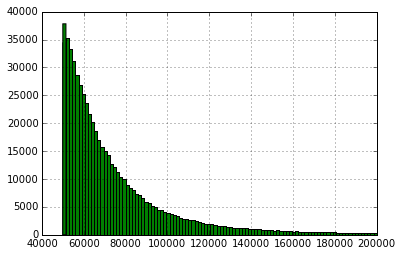

In [82]:
merge.Rbg_2011[((merge.Rbg_2011>50000)
                &(merge.Rbg_2011<200000))].hist(bins = 100)
merge.Rbg_2014[((merge.Rbg_2014>50000)
                &(merge.Rbg_2014<200000))].hist(bins = 100)

In [83]:
import seaborn as sns

In [84]:
merge.NBPAC_2011.head()

0    0
1    0
2    0
3    0
4    0
Name: NBPAC_2011, dtype: float64

In [85]:
merge.Rbg_2011.fillna(0, inplace = True)
merge.Rbg_2014.fillna(0, inplace = True)

In [86]:
#Ancienne version ou on selectionnait que les ménages qui apparetnait à l'ensemble 50000-20000
# df_high_earner = merge[((merge.Rbg_2011>50000)
#                       &(merge.Rbg_2011<200000)
#                       &(merge.Rbg_2014>20000)
#                       & (merge.Rbg_2014<300000))]

In [87]:
#Nouvelle version ou il faut appartenir à l'intervalle de revenu que sur un seule des deux années
df_high_earner = merge[((
            (merge.Rbg_2011>50000)
            &(merge.Rbg_2011<200000)
        )|(
            (merge.Rbg_2014>50000)
            & (merge.Rbg_2014<200000)))]

### Supprime la selection de données et on fait ça dans estimation new
df_high_earner = merge

(0, 300000)

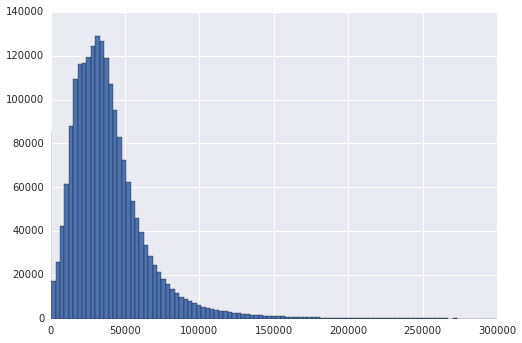

In [88]:
df_high_earner.query("Rbg_2011<300000").Rbg_2011.hist(bins = 1000)
plt.xlim(0,300000)

In [89]:

print (merge.Rbg_2014 - merge.Rbg_2011).mean()
print (df_high_earner.Rbg_2014 - df_high_earner.Rbg_2011).mean()

3434.08729217
3434.08729217


mean reversal or change in distribution ?

In [90]:
df_grpby_first = merge.groupby('ID_FISC_LOG_DIFF_2011').first()
df_high_grpby_first = df_high_earner.groupby('ID_FISC_LOG_DIFF_2011').first()

In [91]:
print (df_grpby_first.Rbg_2014 - df_grpby_first.Rbg_2011).mean()
print (df_high_grpby_first.Rbg_2014 - df_high_grpby_first.Rbg_2011).mean()

3133.21536349
3133.21536349


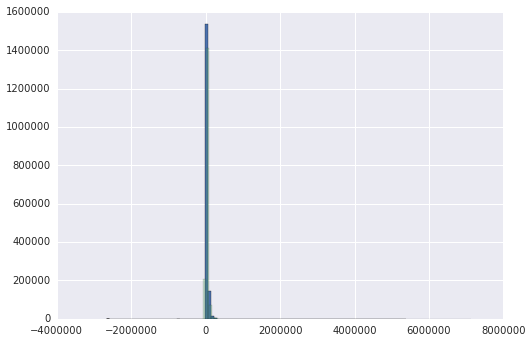

In [92]:
df_high_grpby_first.Rbg_2011.hist(bins = 100)
df_high_grpby_first.Rbg_2014.hist(bins = 100, alpha = 0.3)

In [93]:
print df_high_grpby_first.Rbg_2014.describe()
print df_high_grpby_first.Rbg_2011.describe()

count    1706246.000000
mean       41599.283244
std        38994.185519
min      -776771.300000
25%        21936.100000
50%        35077.500000
75%        51275.525000
max      7140172.200000
Name: Rbg_2014, dtype: float64
count    1706246.000000
mean       38466.067880
std        37460.404536
min     -2666060.000000
25%        19959.300000
50%        32643.000000
75%        47717.100000
max      5377289.600000
Name: Rbg_2011, dtype: float64


In [94]:
print (df_high_grpby_first.NBPAC_2011>0).value_counts()
print (df_high_grpby_first.NBPAC_2011>0).value_counts(normalize = True)

True     867999
False    838247
dtype: int64
True     0.508719
False    0.491281
dtype: float64


In [95]:
same_pac_nb = (df_high_grpby_first.NBPAC_2011 == df_high_grpby_first.NBPAC_2014)
(df_high_grpby_first.NBPAC_2011 == df_high_grpby_first.NBPAC_2014).value_counts()

True     1371615
False     334631
dtype: int64

In [96]:
df_high_grpby_first[same_pac_nb].NBFOYM_2011.value_counts()

1    1017867
2     295199
3      47632
4       8673
5       1700
6        397
7         96
8         32
9         19
dtype: int64

In [97]:
one_tax_unit = (df_high_grpby_first.NBFOYM_2011 == 1)

In [98]:
df_high_grpby_first.NBPERSM_2011.head()

ID_FISC_LOG_DIFF_2011
1    4
3    4
4    4
5    2
7    5
Name: NBPERSM_2011, dtype: float64

In [ ]:
df_high_grpby_first[same_pac_nb & one_tax_unit][["ID_FISC_FOY_DIFF","Rbg_2011","Rbg_2014", "NBPERSM_2011", "NBPERSM_2014"]].head()

In [100]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])

In [101]:
threshold_byr_rbg.index = range(1,7); threshold_byr_rbg.index.name = 'nb_enf'
threshold_byr_rbg


,2011,2014
nb_enf,,
1,63233,58291
2,73516,63530
3,94451,73806
4,115185,84103
5,135941,94368
6,150684,104633


In [102]:
df = df_high_grpby_first

In [103]:
for nb_enf in range(1,7):
    df["Between_threshold_{}_child".format(nb_enf)
          ] = ((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
               & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1]))

In [104]:
for nb_enf in range(1,7): 
    df["Over_threshold_{}_child".format(nb_enf)
          ] =  (df.Rbg_2011 > threshold_byr_rbg["2011"].iloc[nb_enf-1])

In [ ]:
df.head()

In [106]:
threshold_byr_rbg["2011"].iloc[0]

63233

In [107]:
df["Threshold"] = np.zeros(len(df))
df["Threshold_ex_post"] = np.zeros(len(df))

In [108]:
for nb_enf in range(1,7):
    df["Threshold"] += (df.NBPAC_2011 == nb_enf) * threshold_byr_rbg["2011"].iloc[nb_enf-1]

In [109]:
for nb_enf in range(1,7):
    df["Threshold_mordant_{}".format(
            threshold_byr_rbg["2011"].iloc[nb_enf-1])
          ] = (df.NBPAC_2011 == nb_enf) * threshold_byr_rbg["2011"].iloc[nb_enf-1]

In [110]:
for nb_enf in range(1,7):
    df["Threshold_ex_post"] += (df.NBPAC_2014 == nb_enf) * threshold_byr_rbg["2014"].iloc[nb_enf-1]

In [111]:
df.Threshold.value_counts()

0         850762
73516     361185
63233     286543
94451     155774
115185     38409
135941      9922
150684      3651
dtype: int64

In [112]:
df.loc[ df.NBPAC_2011==0, "Threshold"] = 10**9 #met les gens sans enfants a un Overthreshold == 0
df.loc[ df.NBPAC_2011==0, "Threshold_ex_post"] = 10**9 #met les gens sans enfants a un Overthreshold == 0
df["Over_threshold"] = (df.Rbg_2011>df.Threshold).astype('int')

In [113]:
df["Over_threshold_ex_post"] = (df.Rbg_2011>df.Threshold_ex_post).astype('int')

In [114]:
df["Between_thresholds"] = (df["Over_threshold_ex_post"].astype('bool') & ~df["Over_threshold"].astype('bool')).astype('int')

In [115]:
print df.Over_threshold.value_counts(normalize = False)
print df.Over_threshold_ex_post.value_counts(normalize = False)
print (~df.Over_threshold& df.Over_threshold_ex_post).value_counts(normalize = False)

0    1598350
1     107896
dtype: int64
0    1490073
1     216173
dtype: int64
0    1594747
1     111499
dtype: int64


In [116]:
print df.Over_threshold.value_counts(normalize = True)
print df.Over_threshold_ex_post.value_counts(normalize = True)
print ((~df.Over_threshold)& df.Over_threshold_ex_post).value_counts(normalize = True)

0    0.936764
1    0.063236
dtype: float64
0    0.873305
1    0.126695
dtype: float64
0    0.934652
1    0.065348
dtype: float64


In [117]:
pd.crosstab(df[df.NBPAC_2011.isin([0,1,2,3,4,5,6])].Over_threshold, df[df.NBPAC_2011.isin([0,1,2,3,4,5,6])].NBPAC_2011)

NBPAC_2011,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Over_threshold,,,,,,,
0,838247,244379,321126,144223,36446,9662,3578
1,0,42164,40059,11551,1963,260,73


In [118]:
pd.crosstab(df[df.NBPAC_2011.isin([0,1,2,3,4,5,6])].Over_threshold_ex_post, df[df.NBPAC_2011.isin([0,1,2,3,4,5,6])].NBPAC_2011)

NBPAC_2011,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Over_threshold_ex_post,,,,,,,
0,838247,183649,287522,131348,33763,8863,3035
1,0,102894,73663,24426,4646,1059,616


In [119]:
pd.crosstab((~df[df.NBPAC_2011.isin([1,2,3,4,5,6])].Over_threshold)&(df[df.NBPAC_2011.isin([1,2,3,4,5,6])].Over_threshold_ex_post)
            
            , df[df.NBPAC_2011.isin([1,2,3,4,5,6])].NBPAC_2011)

NBPAC_2011,1.0,2.0,3.0,4.0,5.0,6.0
row_0,,,,,,
0,225605,327525,142898,35726,9123,3108
1,60938,33660,12876,2683,799,543


In [120]:
pd.crosstab((df[df.NBPAC_2011.isin([1,2,3,4,5,6])].Between_thresholds)
            
            , df[df.NBPAC_2011.isin([1,2,3,4,5,6])].NBPAC_2011)

NBPAC_2011,1.0,2.0,3.0,4.0,5.0,6.0
Between_thresholds,,,,,,
0,225605,327525,142898,35726,9123,3108
1,60938,33660,12876,2683,799,543


In [121]:
df.shape

(1706246, 295)

In [122]:
for child in range(1,10):
    df["child_{}".format(child)] = (df.NBPAC_2011 == child).astype('int')
for child in range(1,10):
    df["cumulative_child_{}".format(child)] = (df.NBPAC_2011 >= child).astype('int')

In [123]:
child_bool_list = ["child_{}".format(child) for child in  np.arange(1,6)]
cumulative_child_bool_list = ["cumulative_child_{}".format(child) for child in  np.arange(1,6)]

In [124]:
for thrsh in threshold_byr_rbg["2011"]:
    df["Threshold_{}".format(thrsh)] = ((df.Rbg_2011 > thrsh) &(~(df["Threshold_mordant_{}".format(thrsh)]))).astype("int")

In [125]:
thrsh_bool_list = ["Threshold_{}".format(thrsh) for thrsh in  threshold_byr_rbg["2011"]]

In [126]:
reg_df = df[df.NBPAC_2011.isin([0,1,2,3,4,5,6,7])]
#reg_df = reg_df[reg_df.AGERF_2011<60]

In [127]:
reg_df["Log_rbg_2011"] = np.log(reg_df.Rbg_2011)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


On récupère les salaire individuels pour faire YSALI_wo et YSALI_me

In [128]:
id_fisc_foy_diff_2011 = df_2011_keep.ID_FISC_FOY_DIFF
id_fisc_foy_diff_2014 = df_2014_keep.ID_FISC_FOY_DIFF

In [129]:
df_fiscrevdet_2011 = load_df_fiscrevdet_by_year(2011)
df_fiscrevdet_2011["YSALI_wo"] = df_fiscrevdet_2011.YSALI * (df_2011_keep.SEXE==2)
df_fiscrevdet_2011["YSALI_me"] = df_fiscrevdet_2011.YSALI * (df_2011_keep.SEXE==1)

In [130]:
df_fiscrevdet_2011[df_fiscrevdet_2011.ID_FISC_FOY_DIFF.isin(id_fisc_foy_diff_2011)].sort("ID_FISC_FOY_DIFF").TYPE_FISC.value_counts()

1    2111716
2    1118843
3     135260
4      26500
5       2722
6        208
dtype: int64

In [131]:
%%time
df_2014.loc[(df_2014.SEXE == '1')|(df_2014.SEXE == 'C')|df_2014.SEXE.isnull()] = 1
df_2014.loc[(df_2014.SEXE == '2')] = 2



income_vars = ["YSALI", "YALRI", "YCHOI", "YBICI", "YBNCI", "YRAGI", "YRSTI"]
income_vars_me = [string + "_me" for string in income_vars]
income_vars_wo = [string + "_wo" for string in income_vars]

for var in ["YSALI","YALRI", "YCHOI", "YBICI", "YBNCI", "YRAGI", "YRSTI"]:
    df_2011["{}_wo".format(var)] = df_2011["{}".format(var)] * (df_2011.SEXE==2) * (df_2011.TYPE_FISC.isin(["1","2"]))
    df_2011["{}_me".format(var)] = df_2011["{}".format(var)] * (df_2011.SEXE==1)  * (df_2011.TYPE_FISC.isin(["1","2"]))
    df_2014["{}_wo".format(var)] = df_2014["{}".format(var)] * (df_2014.SEXE==2) * (df_2011.TYPE_FISC.isin(["1","2"]))
    df_2014["{}_me".format(var)] = df_2014["{}".format(var)] * (df_2014.SEXE==1) * (df_2011.TYPE_FISC.isin(["1","2"]))



Wall time: 2min 51s


In [132]:
%%time
df_2011["Age_wo"] = (2011 - df_2011.ANAIS) * (df_2011.SEXE==2) * (df_2011.TYPE_FISC.isin(["1","2"]))
df_2011["Age_me"] = (2011 - df_2011.ANAIS) * (df_2011.SEXE==1) * (df_2011.TYPE_FISC.isin(["1","2"]))

df_2011["Id_diff_wo"] = df_2011.ID_DIFF * (df_2011.SEXE==2) * (df_2011.TYPE_FISC.isin(["1","2"])).astype("int")
df_2011["Id_diff_me"] = df_2011.ID_DIFF * (df_2011.SEXE==1) * (df_2011.TYPE_FISC.isin(["1","2"]))




df_2011["working_wo"] = ((df_2011.SEXE==2)&(df_2011.YRSTI==0)&(df_2011.YSALI>1000)&df_2011.TYPE_FISC.isin(['1','2'])).astype("int")
df_2011["working_me"] = ((df_2011.SEXE==1)&(df_2011.YRSTI==0)&(df_2011.YSALI>1000)&df_2011.TYPE_FISC.isin(['1','2'])).astype("int")
df_2014["working_wo"] = ((df_2014.SEXE==2)&(df_2014.YRSTI==0)&(df_2014.YSALI>1000)&df_2011.TYPE_FISC.isin(['1','2'])).astype("int")
df_2014["working_me"] = ((df_2014.SEXE==1)&(df_2014.YRSTI==0)&(df_2014.YSALI>1000)&df_2011.TYPE_FISC.isin(['1','2'])).astype("int")


Wall time: 12.3 s


In [133]:

df_2011_groupby = df_2011[["working_wo", "working_me","ID_FISC_LOG_DIFF", "Age_wo", "Age_me","Id_diff_wo" ,"Id_diff_me"] #TODO: use id_foy instead of id_log
                          +income_vars_me+income_vars_wo].groupby("ID_FISC_LOG_DIFF").sum()
df_2014_groupby = df_2014[["working_wo", "working_me","YSALI_wo", "YSALI_me","ID_FISC_LOG_DIFF" ]
                         +income_vars_me+income_vars_wo].groupby("ID_FISC_LOG_DIFF").sum()
df_working_by_log = pd.merge(df_2011_groupby, df_2014_groupby, left_index=True,right_index=True,
                             suffixes=('_2011','_2014'))


In [134]:
df_2011_groupby.columns

Index([u'working_wo', u'working_me', u'Age_wo', u'Age_me', u'Id_diff_wo',
       u'Id_diff_me', u'YSALI_me', u'YALRI_me', u'YCHOI_me', u'YBICI_me',
       u'YBNCI_me', u'YRAGI_me', u'YRSTI_me', u'YSALI_wo', u'YALRI_wo',
       u'YCHOI_wo', u'YBICI_wo', u'YBNCI_wo', u'YRAGI_wo', u'YRSTI_wo'],
      dtype='object')

In [135]:
df_2011_groupby = df_2011[["working_wo", "working_me","ID_FISC_FOY_DIFF", "Age_wo", "Age_me" ]
                          +income_vars_me+income_vars_wo].groupby("ID_FISC_FOY_DIFF").sum()

In [136]:
income_vars = ["YSALI", "YALRI", "YCHOI", "YBICI", "YBNCI", "YRAGI", "YRSTI"]
income_vars_me = [string + "_me" for string in income_vars]
income_vars_wo = [string + "_wo" for string in income_vars]

In [137]:
income_vars_me

['YSALI_me',
 'YALRI_me',
 'YCHOI_me',
 'YBICI_me',
 'YBNCI_me',
 'YRAGI_me',
 'YRSTI_me']

In [ ]:
df_working_by_log.head()

In [139]:
df_2014[df_2014.SEXE == 2 ].YSALI.describe()

count    1875354.000000
mean        9227.522356
std        14914.105092
min            0.000000
25%            0.000000
50%            2.000000
75%        17342.000000
max      3502247.000000
Name: YSALI, dtype: float64

In [140]:
df_2014[df_2014.SEXE == 1 ].YSALI.describe()

count    1835104.000000
mean       14559.710261
std        26351.797205
min            0.000000
25%            0.000000
50%         2028.500000
75%        23626.000000
max      5393270.000000
Name: YSALI, dtype: float64

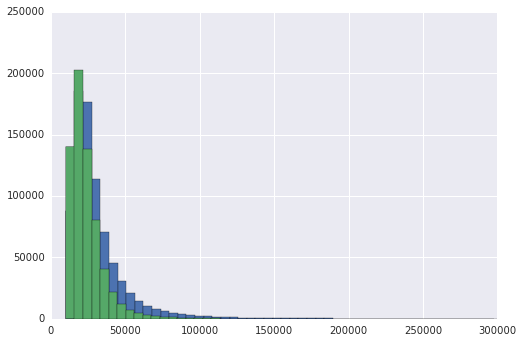

In [141]:
df_2014[df_2014.SEXE == 1 ].query("3*10**5>YSALI>10**4").YSALI.hist(bins= 50)
df_2014[df_2014.SEXE == 2 ].query("3*10**5>YSALI>10**4").YSALI.hist(bins = 50)

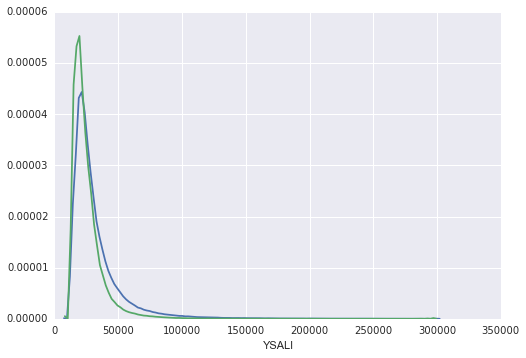

In [142]:
import seaborn as sns
sns.distplot(df_2014[df_2014.SEXE == 1 ].query("3*10**5>YSALI>10**4").YSALI, hist = False)
sns.distplot(df_2014[df_2014.SEXE == 2 ].query("3*10**5>YSALI>10**4").YSALI, hist = False)


In [143]:
%%time
working_by_sex_reg = pd.merge(reg_df, df_working_by_log, left_index=True,right_index=True, )
working_wo_2011 = working_by_sex_reg.working_wo_2011.astype("bool")
not_working_wo_2014 =  ~working_by_sex_reg.working_wo_2014.astype("bool")
working_me_2011 = working_by_sex_reg.working_me_2011.astype("bool")
not_working_me_2014 =  ~working_by_sex_reg.working_me_2014.astype("bool")
working_by_sex_reg["Wo_stopped_working"] =( working_wo_2011 & not_working_wo_2014).astype("int")
working_by_sex_reg["Wo_started_working"] =( ~working_wo_2011 & ~not_working_wo_2014).astype("int")
working_by_sex_reg["Men_stopped_working"] =( working_me_2011 & not_working_me_2014).astype("int")
working_by_sex_reg["Men_started_working"] =( ~working_me_2011 & ~not_working_me_2014).astype("int")

Wall time: 2min 41s


TODO : attention on perd 2000 observations, voir pourquoi

In [144]:
working_by_sex_reg.YSALI_me_2011.describe()

count    1522346.000000
mean       17623.935872
std        27885.992327
min            0.000000
25%            0.000000
50%        13402.500000
75%        26805.000000
max      5952328.000000
Name: YSALI_me_2011, dtype: float64

In [145]:
working_by_sex_reg.YSALI_wo_2014.describe()

,YSALI_wo_2014,YSALI_wo_2014
count,1522264.000000,1522264.000000
mean,10471.002500,10471.002500
std,16196.036127,16196.036127
min,0.000000,0.000000
25%,0.000000,0.000000
50%,59.000000,59.000000
75%,19042.000000,19042.000000
max,3502247.000000,3502247.000000


In [146]:
df_2011_keep.shape

(2111716, 136)

In [147]:
reg_df.shape

(1694900, 320)

In [148]:

working_by_sex_reg[working_by_sex_reg.Wo_started_working==1][["YSALI_wo_2011","YCHOI_wo_2011","YRSTI_wo_2011", "YSALI_wo_2014", "working_wo_2011", "Age_wo"]].head()

,YSALI_wo_2011,YCHOI_wo_2011,YRSTI_wo_2011,YSALI_wo_2014,YSALI_wo_2014,working_wo_2011,Age_wo
7,11,1883,0,25574,25574,0,51
16,17548,0,2400,16684,16684,0,46
38,0,1660,0,11596,11596,0,60
80,0,5603,6322,10024,10024,0,43
97,0,8576,0,5518,5518,0,43


In [149]:
working_by_sex_reg.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1522346 entries, 1.0 to 3667311.0
Columns: 362 entries, ID_DIFF_2014 to Men_started_working
dtypes: bool(12), float64(215), int32(35), int64(73), object(27)
memory usage: 3.8+ GB


In [151]:
s = working_by_sex_reg.columns.to_series()
working_by_sex_reg.columns = s + s.groupby(s).cumcount().astype(str).replace({'0':''})

In [152]:
%%time
working_by_sex_reg.to_hdf(u"C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Programme/Réaction offre de travail/hdf/data_step_1_reaction_offre_travail.h5",
                          "fisci_fiscr_fiscrevdet")
import datetime
print datetime.datetime.now()

2019-05-06 15:52:44.481000
Wall time: 32 s


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\io\pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->['ORDREFIP_2014', 'TYPE_FISC_2014', 'SEXE_2014', 'CODNAIS_2014', 'CIDECI_2014', 'ZOXYZD_2014', 'ZOXYZP_2014', 'CNCOIPV_2014', 'CSDEP_2014', 'DEP_2014', 'DEPCOM_2014', 'I_CHAMPM_2014', 'I_PAUVRE50M_2014', 'I_PAUVRE60M_2014', 'ORDREFIP_2011', 'TYPE_FISC_2011', 'CODNAIS_2011', 'CIDECI_2011', 'ZOXYZD_2011', 'ZOXYZP_2011', 'CNCOIPV_2011', 'CSDEP_2011', 'DEP_2011', 'DEPCOM_2011', 'I_CHAMPM_2011', 'I_PAUVRE50M_2011', 'I_PAUVRE60M_2011']]

  warnings.warn(ws, PerformanceWarning)


In [ ]:
#working_by_sex_reg.Id_diff_me

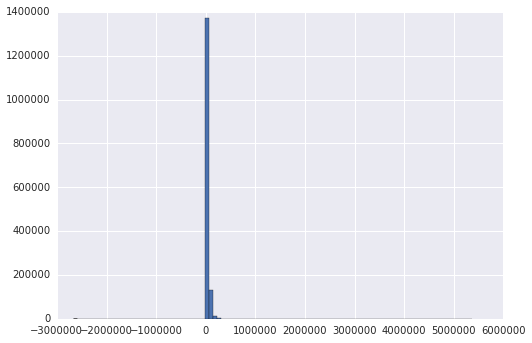

In [153]:
working_by_sex_reg.Rbg_2011.hist(bins = 100)

In [154]:
import datetime
print datetime.datetime.now()

2019-05-06 15:53:00.609000


In [155]:
reg_df_1 = reg_df[["Over_threshold", "Between_thresholds"]+cumulative_child_bool_list+thrsh_bool_list]

In [156]:
3

3

### 

Wall time: 5.81 s


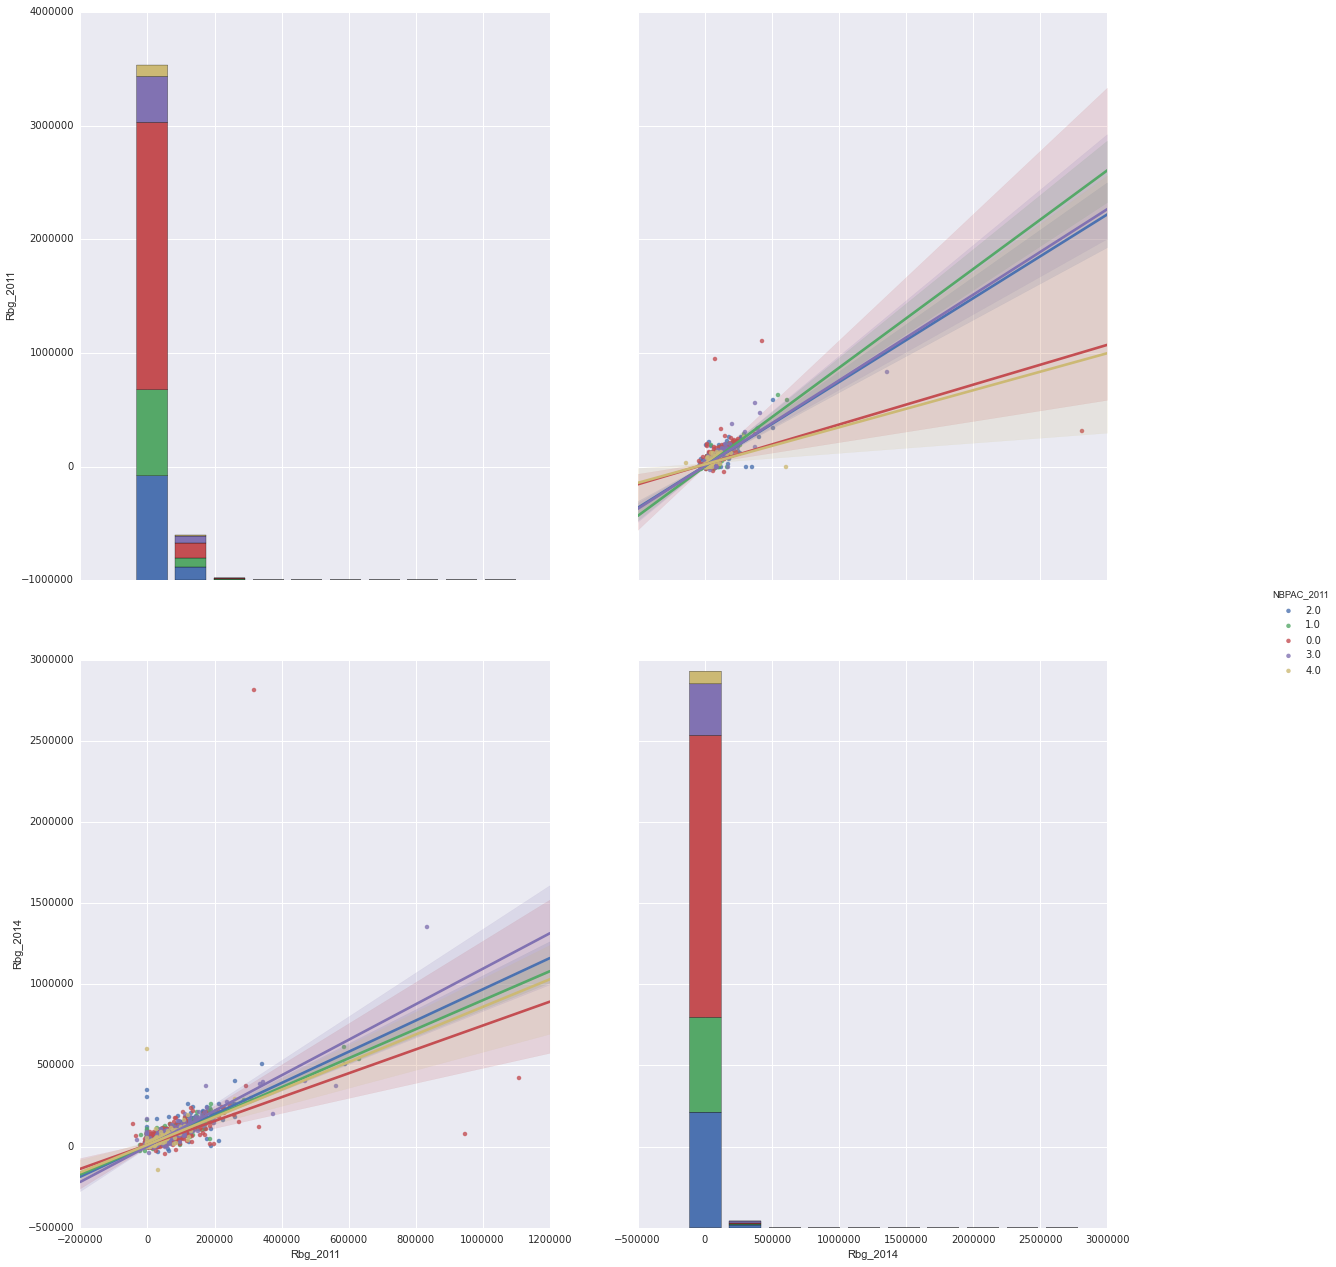

In [157]:
%%time
fig = plt.figure(figsize = (20,20))
g = sns.pairplot(reg_df.head(10000).query("0<=NBPAC_2011<5"),vars = ["Rbg_2011", "Rbg_2014"], hue ="NBPAC_2011", kind = "reg"  )
g.fig.set_size_inches(20,20)